In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from tensorflow import keras

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2021-08-10 04:34:58--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 2.21.40.213, 2a02:26f0:6b:5b3::e59, 2a02:26f0:6b:5a5::e59
Connecting to download.microsoft.com (download.microsoft.com)|2.21.40.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   136MB/s    in 5.9s    

2021-08-10 04:35:04 (133 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [4]:
create_dirs=[
             '/tmp/cats-v-dogs',
             '/tmp/cats-v-dogs/training',
             '/tmp/cats-v-dogs/testing',
             '/tmp/cats-v-dogs/training/cats',
             '/tmp/cats-v-dogs/training/dogs',
             '/tmp/cats-v-dogs/testing/cats',
             '/tmp/cats-v-dogs/testing/dogs'
]

In [5]:
for dirs in create_dirs:
  try:
    os.mkdir(dirs)
    print(dirs,'created')
  except:
    print('creatiion failed')

/tmp/cats-v-dogs created
/tmp/cats-v-dogs/training created
/tmp/cats-v-dogs/testing created
/tmp/cats-v-dogs/training/cats created
/tmp/cats-v-dogs/training/dogs created
/tmp/cats-v-dogs/testing/cats created
/tmp/cats-v-dogs/testing/dogs created


In [10]:
def split_dataset(src,train,test,split):
  files=[]
  for file_name in os.listdir(src):
    file_path=src+file_name
    if os.path.getsize(file_path):
      files.append(file_name)
    else:
      print('{} is zero length'.format(file_name))
  
  nfiles=len(files)
  splitpt=int(nfiles*split)

  shuffled=random.sample(files,nfiles)
  train_set = shuffled[:splitpt]
  test_set = shuffled[splitpt:]
  for file_name in train_set:
        copyfile(src+file_name,train+file_name)
        
  for file_name in test_set:
        copyfile(src+file_name,test+file_name)

In [11]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

In [12]:
split_size = .9
split_dataset(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_dataset(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length
11702.jpg is zero length


In [13]:

print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))


11250
11250
1250
1250


In [14]:

model=tf.keras.Sequential([
                           tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
                           tf.keras.layers.MaxPool2D(2,2),
                           tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
                           tf.keras.layers.MaxPool2D(2,2),
                           tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                           tf.keras.layers.MaxPool2D(2,2),
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(512,activation='relu'),
                           tf.keras.layers.Dense(1,activation='sigmoid')                          
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [16]:

model.compile(optimizer=RMSprop(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
TRAINING_DIR='/tmp/cats-v-dogs/training'
train_datagen=ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )
train_generator=train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=64,
    target_size=(150,150),
    class_mode='binary'
)

VALIDATION_DIR='/tmp/cats-v-dogs/testing'
validation_datagen=ImageDataGenerator(rescale=1/255.0)
validation_generator= validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=64,
    target_size=(150,150),
    class_mode='binary'
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [18]:
history=model.fit(train_generator,epochs=15,verbose=1,validation_data=validation_generator)

Epoch 1/15
177/352 [==============>...............] - ETA: 1:33 - loss: 0.6899 - accuracy: 0.5663

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

352/352 [==============================] - 226s 556ms/step - loss: 0.6635 - accuracy: 0.6090 - val_loss: 0.5629 - val_accuracy: 0.7160
Epoch 2/15
352/352 [==============================] - 196s 557ms/step - loss: 0.5971 - accuracy: 0.6776 - val_loss: 0.5824 - val_accuracy: 0.6864
Epoch 3/15
352/352 [==============================] - 198s 562ms/step - loss: 0.5598 - accuracy: 0.7141 - val_loss: 0.4767 - val_accuracy: 0.7684
Epoch 4/15
352/352 [==============================] - 198s 561ms/step - loss: 0.5459 - accuracy: 0.7254 - val_loss: 0.4496 - val_accuracy: 0.8080
Epoch 5/15
352/352 [==============================] - 196s 558ms/step - loss: 0.5239 - accuracy: 0.7386 - val_loss: 0.4301 - val_accuracy: 0.8076
Epoch 6/15
352/352 [==============================] - 198s 562ms/step - loss: 0.5053 - accuracy: 0.7560 - val_loss: 0.4055 - val_accuracy: 0.8088
Epoch 7/15
352/352 [==============================] - 196s 557ms/step - loss: 0.4913 - accuracy: 0.7669 - val_loss: 0.4005 - val_accura

Text(0.5, 1.0, 'Training and validation loss')

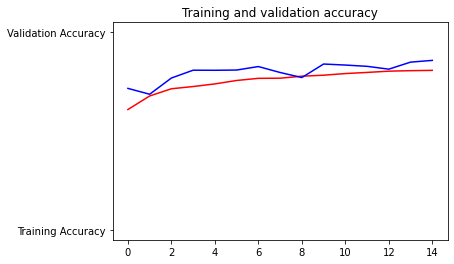

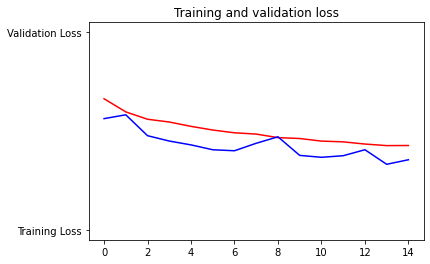

In [19]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [20]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")